In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import esmlab
import utils
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

In [2]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/month_1'
variables = ['diatChl', 'coccoChl','spChl','diazChl','mesozooC']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT']
path

'/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/month_1'

### get monthly data and immediately convert it to annual

In [3]:
def preprocess(ds):
    #ds=ds.isel(z_t=0)
    ds=ds.isel(z_t_150m=0)
    return ds

In [4]:
def preprocess2(ds):
    #ds=ds.isel(z_t=0)
    ds=ds.mean(dim='z_t_150m')
    return ds

In [5]:
%%time

ds_ann = xr.Dataset()

for year in np.arange(1997,2006,1):
    yr4="{:04d}".format(year)
    ds = xr.Dataset()
    print(year)
    for v in variables:  
        print(v)
        files = sorted(glob(f'{path}/{case}.pop.h.{v}.{yr4}01-{yr4}12.nc'))
        
        if v=='mesozooC':
            print('got mesozoo, making avg')
            dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess2)
        else:
            print('got a chl var, getting surf')
            dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

        ds = xr.merge((ds, dsv))

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    ds = ds.mean(dim='time')
    
    ## add it to the annual file
    ds_ann = xr.concat([ds_ann, ds], "time")

1997
diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl var, getting surf
diazChl
got a chl var, getting surf
mesozooC
got mesozoo, making avg
1998
diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl var, getting surf
diazChl
got a chl var, getting surf
mesozooC
got mesozoo, making avg
1999
diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl var, getting surf
diazChl
got a chl var, getting surf
mesozooC
got mesozoo, making avg
2000
diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl var, getting surf
diazChl
got a chl var, getting surf
mesozooC
got mesozoo, making avg
2001
diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl var, getting surf
diazChl
got a chl var, getting surf
mesozooC
got mesozoo, making avg
2002
diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl v

In [6]:
ds_ann

<xarray.Dataset>
Dimensions:   (nlat: 2400, nlon: 3600, time: 9, z_t: 62)
Coordinates:
    TLONG     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLAT      (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nlat, nlon, time, z_t
Data variables:
    coccoChl  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    diazChl   (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    spChl     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    diatChl   (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    mesozooC  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    KMT       (time, nlat, nlon) float64 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    dz        (time, z_t) float32 dask.array<chunksize=(1, 62), meta=np.ndarray>

### get 5 day output and convert to annual, from 2006 to 2021

In [7]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_5'

In [8]:
f'{path}/{case}.pop.h.nday5.{v}.{yr4}01??-{yr4}12??.nc'

'/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_5/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday5.mesozooC.200501??-200512??.nc'

In [9]:
year = 2006
yr4="{:04d}".format(year)
year2 = year + 1
yr4b = "{:04d}".format(year)
v=variables[0]
files = sorted(glob(f'{path}/{case}.pop.h.nday5.{v}.{yr4}????-????????.nc'))
files

['/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_5/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday5.diatChl.20060101-20070101.nc']

In [10]:
%%time

for year in np.arange(2006,2022,1):
    yr4="{:04d}".format(year)
    ds = xr.Dataset()
    print(year)
    for v in variables:  
        print(v)
        files = sorted(glob(f'{path}/{case}.pop.h.nday5.{v}.{yr4}????-????????.nc'))
        if v=='mesozooC':
            print('got mesozoo, making avg')
            dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess2)
        else:
            print('got a chl var, getting surf')
            dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

        ds = xr.merge((ds, dsv))

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    ds = ds.mean(dim='time')
    
    ## add it to the annual file
    ds_ann = xr.concat([ds_ann, ds], "time")

2006
diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl var, getting surf
diazChl
got a chl var, getting surf
mesozooC
got mesozoo, making avg
2007
diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl var, getting surf
diazChl
got a chl var, getting surf
mesozooC
got mesozoo, making avg
2008
diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl var, getting surf
diazChl
got a chl var, getting surf
mesozooC
got mesozoo, making avg
2009
diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl var, getting surf
diazChl
got a chl var, getting surf
mesozooC
got mesozoo, making avg
2010
diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl var, getting surf
diazChl
got a chl var, getting surf
mesozooC
got mesozoo, making avg
2011
diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl v

In [11]:
ds_ann

<xarray.Dataset>
Dimensions:   (nlat: 2400, nlon: 3600, time: 25, z_t: 62)
Coordinates:
    TLONG     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLAT      (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nlat, nlon, time, z_t
Data variables:
    coccoChl  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    diazChl   (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    spChl     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    diatChl   (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    mesozooC  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    KMT       (time, nlat, nlon) float64 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    dz        (time, z_t) float32 dask.array<chunksize=(1, 62), meta=np.ndarray>

### spin up some dask to make the processing faster

In [12]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='256GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=256GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [13]:
cluster, client = get_ClusterClient()
cluster.scale(8) 

In [14]:
client

Client Scheduler: tcp://10.12.206.56:33305 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [15]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')

area = ds_grid.TAREA
lats = ds_grid.TLAT
lons = ds_grid.TLONG

### Make a mean over the satellite era, add the 4 PFT chl together, and then the chlorophyll data is ready

In [16]:
ds = ds_ann.mean(dim='time')

In [17]:
#ds = ds.compute()

In [18]:
ds

<xarray.Dataset>
Dimensions:   (nlat: 2400, nlon: 3600, z_t: 62)
Coordinates:
    TLONG     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLAT      (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    coccoChl  (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    diazChl   (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    spChl     (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    diatChl   (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    mesozooC  (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT       (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    dz        (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>

In [19]:
cesm_chl = ds.diatChl + ds.spChl + ds.coccoChl + ds.diazChl

### Get the satellite data for chlorophyll

In [20]:
path = '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_'
files = []
files.extend(sorted(glob(f'{path}*.nc')))
ds_sat=xr.open_mfdataset(files,concat_dim='time',combine='nested')
ds_sat = ds_sat.mean(dim='time')

### Get the COPEPOD database

In [21]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file, consolidated=False)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

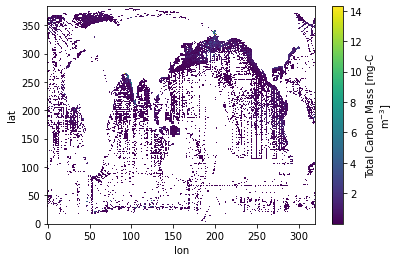

In [22]:
ds_copepod['copepod_C'].plot()

### Make the chlorophyll and copepod maps!

In [23]:
ds_grid_x1 = pop_tools.get_grid('POP_gx1v7')
lons_x1=ds_grid_x1.TLONG
lats_x1=ds_grid_x1.TLAT

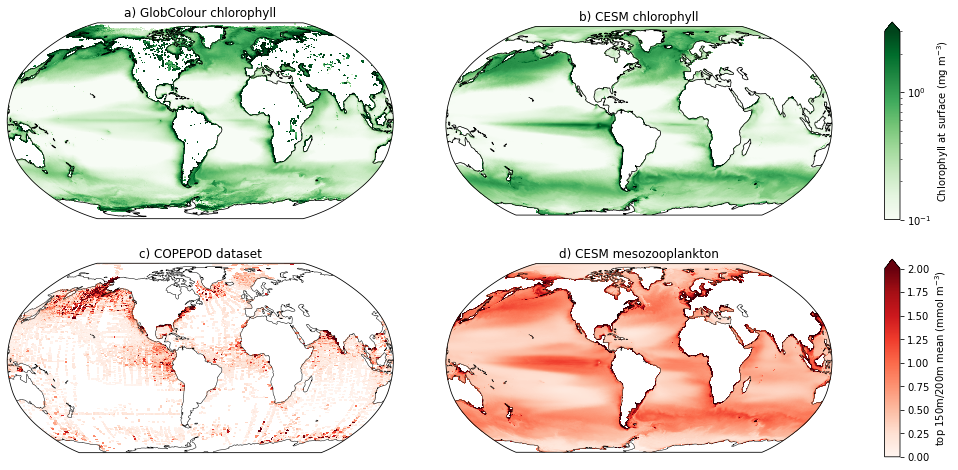

In [25]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 0.04))

prj = ccrs.Robinson(central_longitude=305.0)

ax_chl_sat = plt.subplot(gs[0, 0], projection=prj)
ax_chl_cesm = plt.subplot(gs[0, 1], projection=prj)
ax_meso_cope = plt.subplot(gs[1, 0], projection=prj)
ax_meso_cesm = plt.subplot(gs[1, 1], projection=prj)

ax_chl_sat.set_title('a) GlobColour chlorophyll', fontsize=12)
pc_chl_sat=ax_chl_sat.pcolormesh(ds_sat.lon, ds_sat.lat, ds_sat.CHL1_mean, 
                     cmap='Greens',norm=colors.LogNorm(vmin=0.1, vmax=3),
                     transform=ccrs.PlateCarree())
ax_chl_sat.coastlines('110m',linewidth=0.75)

ax_chl_cesm.set_title('b) CESM chlorophyll', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_chl)
ax_chl_cesm.coastlines('110m',linewidth=0.75)
pc_chl_cesm=ax_chl_cesm.pcolormesh(lon, lat, field, cmap='Greens',
                 norm=colors.LogNorm(vmin=0.1, vmax=3),transform=ccrs.PlateCarree())




ax_meso_cope.set_title('c) COPEPOD dataset', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_copepod.copepod_C)
pc_meso_cope=ax_meso_cope.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax_meso_cope.coastlines('110m',linewidth=0.5)

ax_meso_cesm.set_title('d) CESM mesozooplankton', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds.mesozooC)
pc_meso_cesm=ax_meso_cesm.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax_meso_cesm.coastlines('110m',linewidth=0.5)

cax_chl = plt.subplot(gs[0, 2])
cax_meso = plt.subplot(gs[1, 2])

cb_chl = plt.colorbar(pc_chl_cesm, cax=cax_chl,extend='max', 
                      label='Chlorophyll at surface (mg m$^{-3}$)')
cb_meso = plt.colorbar(pc_meso_cesm, cax=cax_meso,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)')


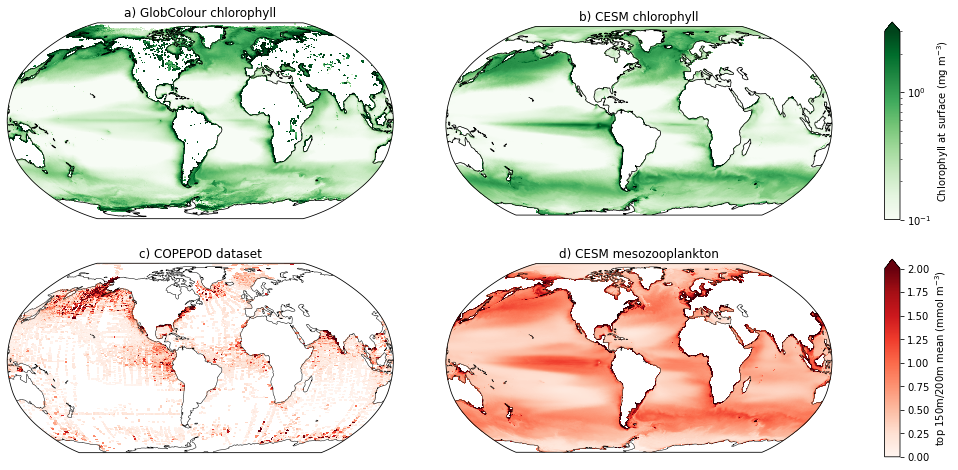

In [26]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 0.04))

prj = ccrs.Robinson(central_longitude=305.0)

ax_chl_sat = plt.subplot(gs[0, 0], projection=prj)
ax_chl_cesm = plt.subplot(gs[0, 1], projection=prj)
ax_meso_cope = plt.subplot(gs[1, 0], projection=prj)
ax_meso_cesm = plt.subplot(gs[1, 1], projection=prj)

ax_chl_sat.set_title('a) GlobColour chlorophyll', fontsize=12)
pc_chl_sat=ax_chl_sat.pcolormesh(ds_sat.lon, ds_sat.lat, ds_sat.CHL1_mean, 
                     cmap='Greens',norm=colors.LogNorm(vmin=0.1, vmax=3),
                     transform=ccrs.PlateCarree())
ax_chl_sat.coastlines('110m',linewidth=0.75)

ax_chl_cesm.set_title('b) CESM chlorophyll', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_chl)
ax_chl_cesm.coastlines('110m',linewidth=0.75)
pc_chl_cesm=ax_chl_cesm.pcolormesh(lon, lat, field, cmap='Greens',
                 norm=colors.LogNorm(vmin=0.1, vmax=3),transform=ccrs.PlateCarree())




ax_meso_cope.set_title('c) COPEPOD dataset', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_copepod.copepod_C)
pc_meso_cope=ax_meso_cope.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax_meso_cope.coastlines('110m',linewidth=0.5)

ax_meso_cesm.set_title('d) CESM mesozooplankton', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds.mesozooC)
pc_meso_cesm=ax_meso_cesm.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax_meso_cesm.coastlines('110m',linewidth=0.5)

cax_chl = plt.subplot(gs[0, 2])
cax_meso = plt.subplot(gs[1, 2])

cb_chl = plt.colorbar(pc_chl_cesm, cax=cax_chl,extend='max', 
                      label='Chlorophyll at surface (mg m$^{-3}$)')
cb_meso = plt.colorbar(pc_meso_cesm, cax=cax_meso,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)')




fig.savefig('/glade/work/kristenk/figs/Fig3_chl_copepod_comparison.png', bbox_inches='tight', dpi=300, format='png');